# 1, 2, 5 steps back -- mode prediction -- operator 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [3]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

## Processing functions

In [4]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [5]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))
    
    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, n_steps_in:int, n_steps_out:int, test_train='Test'):
    fig = plt.figure(figsize=(16, 6))
    pred = plt.plot(np.array(pred), color=mode_colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=mode_colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nTraining features: {comb}\nLook-back: {n_steps_in}, Looh-ahead: {n_steps_out}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.show()
    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()
    return fig


'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()
    return fig

In [6]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

In [7]:
overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']
test = read_dataset(dataset, campaigns=[overlap[0]])
train = read_dataset(dataset, campaigns=overlap[1:4])

route_to_add = read_dataset(dataset, campaigns=[overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(dataset, campaigns=[overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [8]:
# parameters
n_steps_in = 2
n_steps_out = 5
units = [[5, 5], [5, 10], [10, 10], [5, 5, 5], [5, 5, 10], [5, 10, 5], [10, 5, 5], [5, 10, 10], [10, 5, 10], [10, 10, 5], [10, 10, 10], [10, 20, 10], [5, 5, 5, 5], [10, 10, 10, 10]]
features = ['RSRP', 'SSS_RSRP']
 
results = {}

for unit in units:
    layers = ' ->'.join(map(str, unit))
    warnings.simplefilter(action='ignore')
    features.extend(['campaign', 'Mode'])
    results[layers] = long_short_term_memory(train=train[features], test=test[features], target_feature='Mode', features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=unit)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,5 ->5,0.549,0.000,0.000,0.773,0.000,0.000
1,5 ->10,0.680,0.595,0.912,0.471,0.294,0.949
2,10 ->10,0.674,0.602,0.814,0.561,0.329,0.899
3,5 ->5 ->5,0.549,0.000,0.000,0.773,0.000,0.000
4,5 ->5 ->10,0.456,0.446,0.854,0.306,0.171,0.536
5,5 ->10 ->5,0.667,0.580,0.939,0.469,0.289,0.917
6,10 ->5 ->5,0.692,0.607,0.895,0.530,0.308,0.861
7,5 ->10 ->10,0.656,0.606,0.680,0.525,0.318,0.958
8,10 ->5 ->10,0.458,0.454,1.000,0.282,0.233,0.948
9,10 ->10 ->5,0.549,0.000,0.000,0.773,0.000,0.000


In [10]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## look-back = 1   &   look-ahead = 1

In [11]:
units = [10, 10, 10]

n_steps_in, n_steps_out = 1, 1

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.548,0.000,0.000,0.773,0.000,0.000
1,SINR,0.548,0.000,0.000,0.773,0.000,0.000
2,RSRQ,0.548,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.548,0.000,0.000,0.773,0.000,0.000
4,"RSRP, RSRQ",0.548,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.575,0.590,0.196,0.771,0.479,0.069
6,"RSRP, SINR, RSRQ",0.545,0.472,0.070,0.780,0.556,0.164
7,SSS_RSRP,0.594,0.552,0.545,0.562,0.081,0.089
8,SSS_SINR,0.563,0.586,0.107,0.746,0.424,0.330
9,SSS_RSRQ,0.659,0.651,0.527,0.701,0.425,0.900


In [12]:
accuracy = df_results['Accuracy'].mean()
precision = df_results['Precision'].mean()
recall = df_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.586
Mean precision: 0.361
Mean recall: 0.232


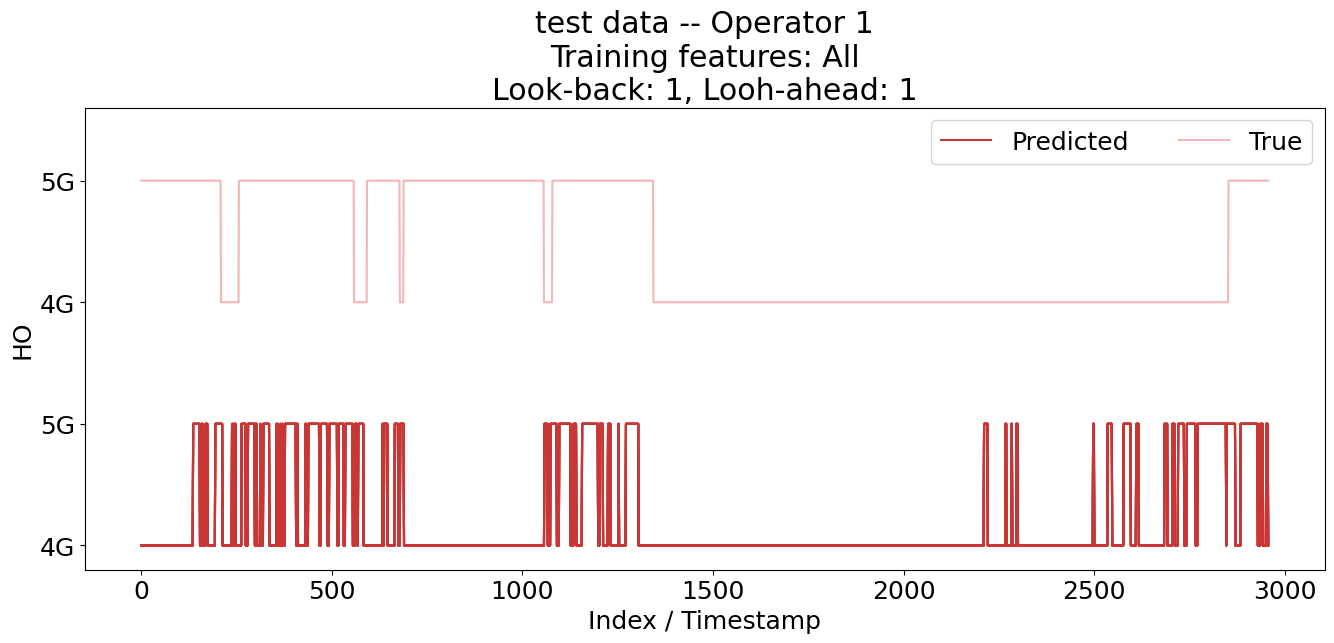

In [13]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, test_train='test', comb=combination, n_steps_in=n_steps_in, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op1_1_look-back_1_look-ahead.pdf')

## look-back = 2   &   look-ahead = 1

In [14]:
n_steps_in, n_steps_out = 2, 1

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.549,0.509,0.043,0.762,0.420,0.123
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.547,0.468,0.027,0.746,0.294,0.083
4,"RSRP, RSRQ",0.527,0.101,0.006,0.768,0.386,0.038
5,"SINR, RSRQ",0.534,0.287,0.022,0.777,0.633,0.048
6,"RSRP, SINR, RSRQ",0.596,0.528,0.971,0.500,0.270,0.707
7,SSS_RSRP,0.585,0.620,0.211,0.717,0.171,0.064
8,SSS_SINR,0.565,0.579,0.138,0.742,0.433,0.444
9,SSS_RSRQ,0.649,0.658,0.463,0.725,0.443,0.821


In [15]:
accuracy = df_results['Accuracy'].mean()
precision = df_results['Precision'].mean()
recall = df_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.589
Mean precision: 0.448
Mean recall: 0.288


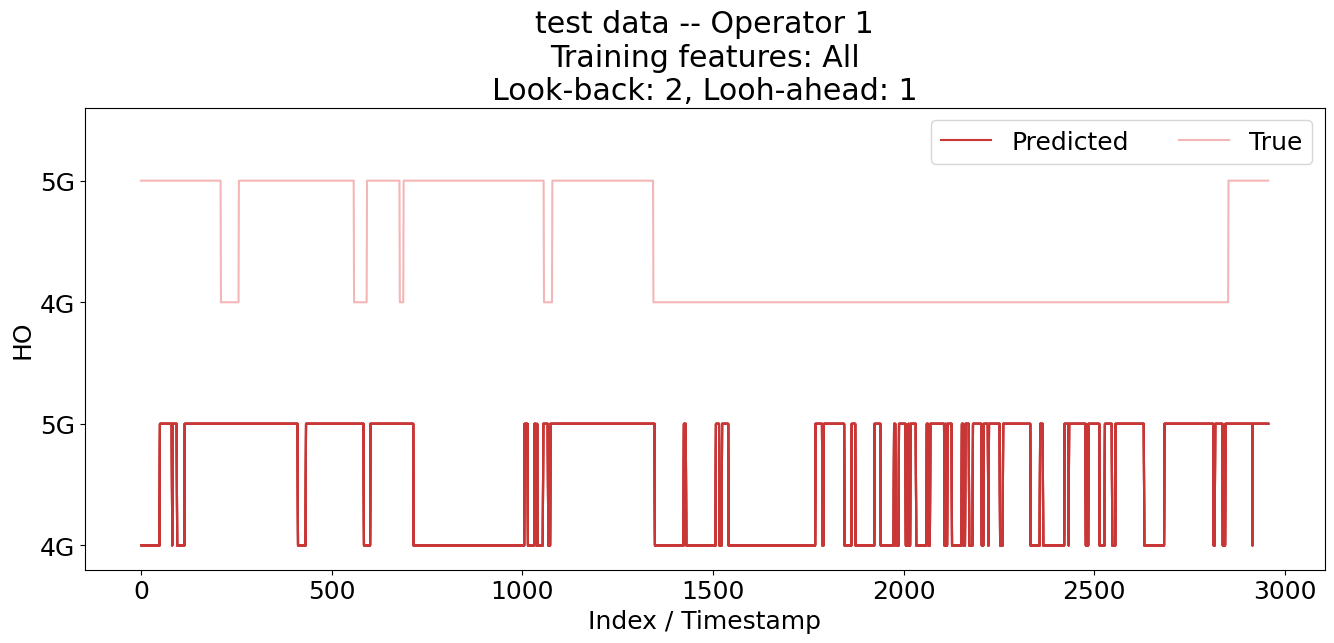

In [16]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, test_train='test', comb=combination, n_steps_in=n_steps_in, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op1_2_look-back_1_look-ahead.pdf')

## look-back = 3   &   look-ahead = 1

In [17]:
n_steps_in, n_steps_out = 3, 1

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.537,0.250,0.014,0.777,0.567,0.070
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.539,0.463,0.138,0.764,0.462,0.232
4,"RSRP, RSRQ",0.525,0.094,0.006,0.765,0.357,0.043
5,"SINR, RSRQ",0.613,0.647,0.314,0.770,0.487,0.215
6,"RSRP, SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.350,0.210,0.160,0.465,0.001,0.002
8,SSS_SINR,0.559,0.589,0.072,0.747,0.350,0.134
9,SSS_RSRQ,0.631,0.652,0.391,0.734,0.449,0.767


In [18]:
accuracy = df_results['Accuracy'].mean()
precision = df_results['Precision'].mean()
recall = df_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.567
Mean precision: 0.452
Mean recall: 0.201


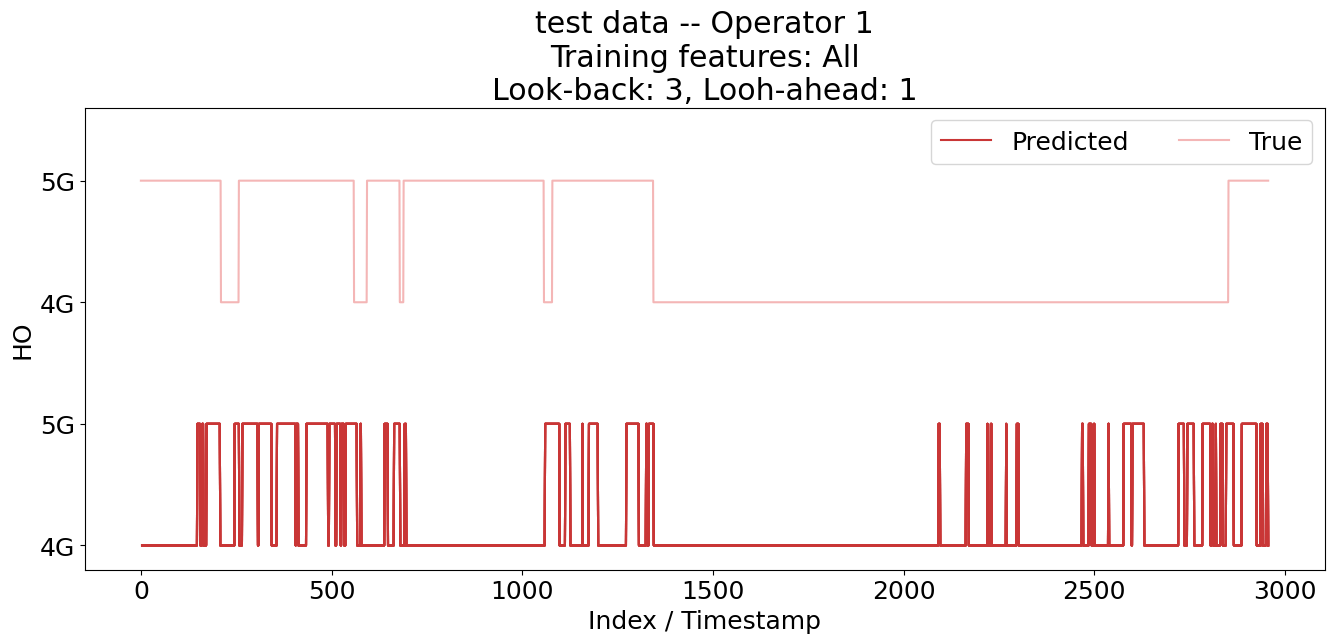

In [19]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, test_train='test', comb=combination, n_steps_in=n_steps_in, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op1_3_look-back_1_look-ahead.pdf')

## look-back = 5   &   look-ahead = 1

In [20]:
n_steps_in, n_steps_out = 5, 1

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.535,0.373,0.045,0.771,0.485,0.218
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.550,0.508,0.093,0.657,0.202,0.175
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.597,0.631,0.256,0.772,0.493,0.324
6,"RSRP, SINR, RSRQ",0.607,0.769,0.183,0.779,0.577,0.095
7,SSS_RSRP,0.549,0.000,0.000,0.773,0.000,0.000
8,SSS_SINR,0.571,0.588,0.163,0.749,0.447,0.459
9,SSS_RSRQ,0.595,0.612,0.276,0.749,0.465,0.718


In [21]:
accuracy = df_results['Accuracy'].mean()
precision = df_results['Precision'].mean()
recall = df_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.575
Mean precision: 0.462
Mean recall: 0.260


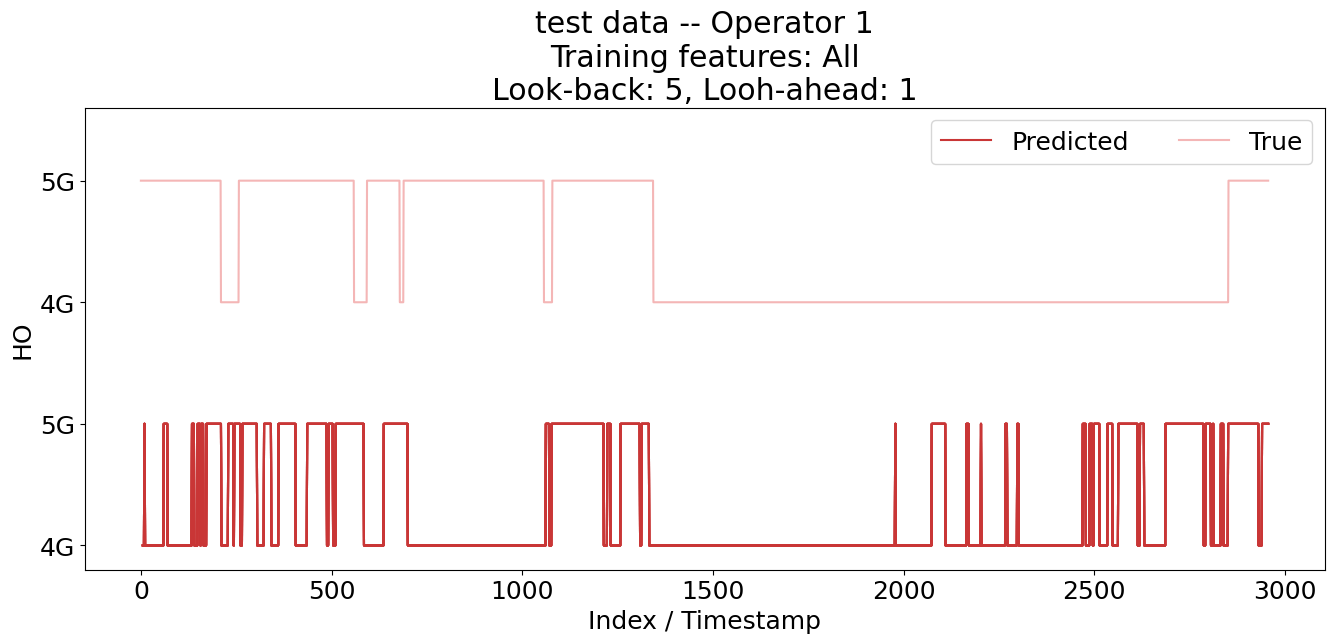

In [22]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, test_train='test', comb=combination, n_steps_in=n_steps_in, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op1_5_look-back_1_look-ahead.pdf')